In [142]:
import os
import re
import time

import pickle
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from html.parser import HTMLParser
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

%matplotlib inline

In [150]:
FB_USERNAME = ''
FB_USERID = ''
FB_PASSWORD = ''

FRIENDS_URLS_FILENAME = 'friends_urls.pickle'
GRAPH_FILENAME = 'friend_graph.pickle'

In [ ]:
# launch the scraper
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications": 2}
chrome_options.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome(options=chrome_options)
driver.get('http://www.facebook.com/')

In [ ]:
# authenticate into Facebook
elem = driver.find_element("id", "email")
elem.send_keys(FB_USERNAME)
elem = driver.find_element("id", "pass")
elem.send_keys(FB_PASSWORD)
elem.send_keys(Keys.RETURN)
time.sleep(5)

In [ ]:
# load, expand and return a page
def get_fb_page(url):
    time.sleep(5)
    driver.get(url)

    last_height = driver.execute_script("return document.body.scrollHeight")
    print('last_height:', last_height)

    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")

        print('new_height:', new_height)
        if new_height == last_height:
            break
        last_height = new_height

    return driver.page_source

In [ ]:
# filter the page to get the friends URLs
class FriendsURLsParser(HTMLParser):
    urls = []

    def error(self, message):
        pass

    def handle_starttag(self, tag, attrs):
        if tag == "a":
            class_name = "x1i10hfl xjbqb8w x1ejq31n xd10rxx x1sy0etr x17r0tee x972fbf xcfux6l x1qhh985 xm0m39n x9f619 x1ypdohk xt0psk2 xe8uvvx xdj266r x11i5rnm xat24cr x1mh8g0r xexx8yu x4uap5 x18d9i69 xkhd6sd x16tdsg8 x1hl2dhg xggy1nq x1a2a7pz x1sur9pj xkrqix3 xi81zsa xo1l8bm"
            ok = False
            for name, value in attrs:
                if name == "class" and value == class_name:
                    ok = True
                if name == "href" and ok:
                    self.urls.append(value)   

In [ ]:
# get my Facebook friends
friends_page = get_fb_page(f'https://www.facebook.com/{FB_USERID}/friends')

friends_urls_parser = FriendsURLsParser()
friends_urls_parser.feed(friends_page)
friends_urls = set(friends_urls_parser.urls)

with open(FRIENDS_URLS_FILENAME, 'wb') as f:
    pickle.dump(friends_urls, f)

print(f'We saved {len(friends_urls)} friends')

In [145]:
# load friends
with open(FRIENDS_URLS_FILENAME, 'rb') as f:
    friends_urls = pickle.load(f)

print(f'We loaded {len(friends_urls)} friends')

We loaded 354 friends


In [146]:
# init graph
friends_connections = {}

if os.path.isfile(GRAPH_FILENAME):
    with open(GRAPH_FILENAME, 'rb') as f:
        friends_connections = pickle.load(f)
    print('Loaded existing graph, found {} keys'.format(len(friends_connections.keys())))

Loaded existing graph, found 354 keys


In [ ]:
# filter friend name or id from URL

# examples of URLs:
# https://www.facebook.com/john.john.3/friends_mutual -> john.john.3
# https://www.facebook.com/profile.php?id=123456789&sk=friends_mutual -> 123456789

def find_friend_from_url(url):
    m = re.search(r'profile\.php\?id=(\d+)', url)
    if m:
        return m.group(1)
    m = re.search(r'facebook\.com/([^/]+)', url)
    if m:
        return m.group(1)
    return None

In [ ]:
# get mutual friends

# count = 0
for friend_url in tqdm(friends_urls):

    print('friend_url:', friend_url)

    friend_username_or_id = find_friend_from_url(friend_url)
    if (friend_username_or_id in friends_connections.keys()) and (len(friends_connections[friend_username_or_id]) > 1):
        continue

    print('friend_username_or_id:', friend_username_or_id)

    friends_connections[friend_username_or_id] = [FB_USERNAME]

    mutual_friends_page = get_fb_page(friend_url)

    parser = FriendsURLsParser()
    parser.urls = []
    parser.feed(mutual_friends_page)
    mutual_friends_urls = set(parser.urls)
    print(f'Found {len(mutual_friends_urls)} mutual friends')

    for mutual_url in mutual_friends_urls:
        mutual_friend = find_friend_from_url(mutual_url)
        friends_connections[friend_username_or_id].append(mutual_friend)

    with open(GRAPH_FILENAME, 'wb') as f:
        pickle.dump(friends_connections, f)

    # count += 1
    # if count % 100 == 0:
    #     print ("Too many queries, pause for a while...")
    #     time.sleep(1800)

    time.sleep(2)

In [148]:
# load connections
with open(GRAPH_FILENAME, 'rb') as f:
    friends_connections = pickle.load(f)

print('friends:', len(list(friends_connections.keys())))

central_friends = {}
for k, v in friends_connections.items():
    print('k:', k, 'v:', v)
    # intersection_size = len(np.intersect1d(list(friends_connections.keys()), v))
    # if intersection_size > 2:
    central_friends[k] = v

# print('Firtered out {} items'.format(len(friends_connections.keys()) - len(central_friends.keys())))

friends: 354
k: 61553641387093 v: ['corentin.chapellier@gmail.com', 'mateo.raekelboom.3', 'valere.crahay', 'alexis.jacques.712', 'esteban.hubert.9', 'thomas.bandin.96', 'alexandremathay.2001', 'arnaud.quinet.3']
k: adrien.renkin.5 v: ['corentin.chapellier@gmail.com', 'axel.friob', '100007587528836', 'arthur.kuborn.7', 'adrien.verhaeghe.5', 'arnaud.fanovard', 'antoine.quertenmont', 'alicia.reydams', '100006102438551']
k: medy.schmit v: ['corentin.chapellier@gmail.com', 'isiclamp.cercledepierrard', '100010034287477', '100006102438551', 'felix.hubert.946', 'Pironallan', 'thibault.scholer', 'antoine.bruno.188', 'sylvain.defraigne', 'adrien.verhaeghe.5', '100011465732691', 'clement.baijot.52', '100008818452118', 'alexandremathay.2001', 'william.alex.5891', '100008303253959', 'antoine.quertenmont', '100010618816737', '100005799160906', 'clement.hoscheit', 'noe.claude.13', '100009119516091', 'justin.picard.50746', '100006322537925', 'balantrobin']
k: thomas.fortemaison.1 v: ['corentin.chapell

In [ ]:
# create edges

edges = []
nodes = [FB_USERID]

for k, v in central_friends.items():
    for item in v:
        if item in central_friends.keys() or item == FB_USERID:
            edges.append((k, item))

In [151]:
# create the graph

G = nx.Graph()
G.add_nodes_from([FB_USERID])
G.add_nodes_from(central_friends.keys())

G.add_edges_from(edges)
print('Added {} edges'.format(len(edges) ))

Added 14755 edges


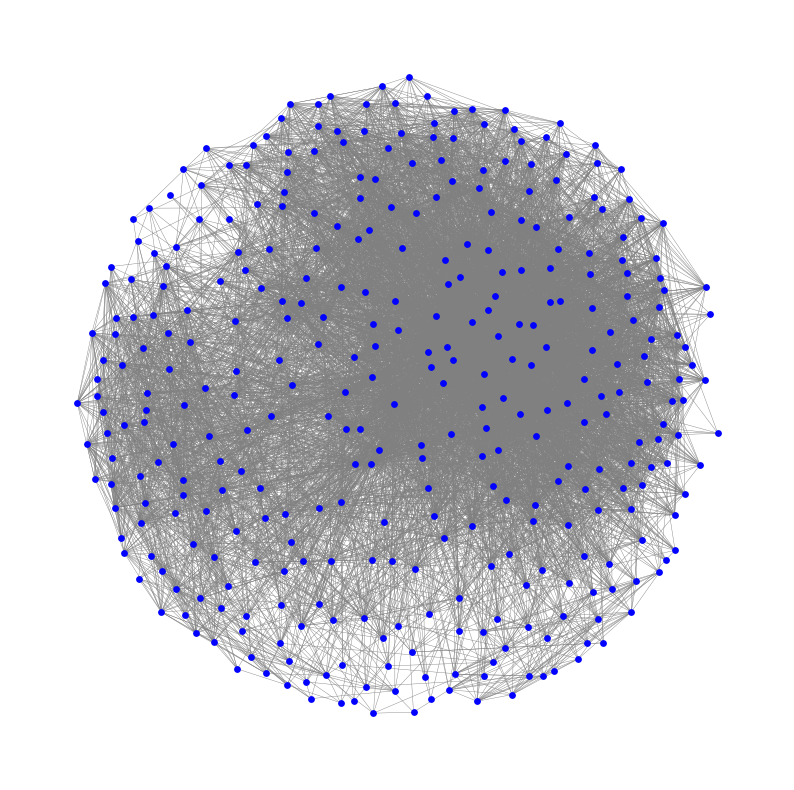

In [166]:
# preview graph

# layout algorithm
pos = nx.kamada_kawai_layout(G)

plt.rcParams['figure.figsize'] = [10, 10]

nx.draw_networkx(G, pos=pos, with_labels=False, node_size=15, width=0.3, node_color='blue', edge_color='grey')

limits = plt.axis('off')

In [ ]:
# save for external Gephi visualization
nx.write_gexf(G, "fb_graph.gexf")